In [2]:
import os
import glob
import numpy as np
import librosa
import python_speech_features as psf
import matplotlib.pyplot as plt
import joblib
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import det_curve

# --- CONFIGURATION ---
INPUT_ROOT = "./dataset_loc_preparé"
MODELS_DIR = "./trained_models_per_person"

# Paramètres MFCC
NUM_CEP = 13
WIN_FUNC = np.hamming

# Paramètres d'étude
N_COMPONENTS_LIST = [16, 32, 64, 128, 256]
TRAIN_DURATIONS = ["1min", "2min"]
TEST_DURATIONS = ["5s", "10s", "15s"]

# Création du dossier de stockage
os.makedirs(MODELS_DIR, exist_ok=True)

print("✅ Environnement configuré.")

✅ Environnement configuré.


In [4]:
def get_clean_features(file_path):
    """Extraction MFCC + Delta + Suppression Silence Hybride"""
    try:
        # 1. Chargement
        signal, sr = librosa.load(file_path, sr=None)
        if len(signal.shape) > 1: signal = signal[0]

        # 2. MFCC
        n_fft = 1024 if sr <= 16000 else 2048
        mfccs = psf.mfcc(signal, sr, numcep=NUM_CEP, nfft=n_fft, winfunc=WIN_FUNC, appendEnergy=False)
        if len(mfccs) < 10: return None

        # 3. Silence Removal (HYBRIDE)
        energies = np.sum(np.square(mfccs), axis=1).reshape(-1, 1)
        
        # KMeans
        kmeans = KMeans(n_clusters=2, n_init='auto', random_state=0).fit(energies)
        # GMM Energie
        gmm_energy = GaussianMixture(n_components=2, random_state=42).fit(energies)
        
        # Seuil Hybride : moyenne des centres de silence
        threshold = (np.min(gmm_energy.means_) + np.min(kmeans.cluster_centers_)) / 2
        is_speech = (energies > threshold).flatten()

        clean_mfcc = mfccs[is_speech]
        if len(clean_mfcc) < 2: return None

        # 4. Deltas
        deltas = psf.delta(clean_mfcc, 2)
        return np.hstack((clean_mfcc, deltas))
    except:
        return None

print("✅ Fonction d'extraction prête.")

✅ Fonction d'extraction prête.


In [6]:
def run_training():
    persons = [d for d in os.listdir(INPUT_ROOT) if os.path.isdir(os.path.join(INPUT_ROOT, d))]

    for person in persons:
        print(f"\n👤 Traitement : {person}")
        person_dir = os.path.join(MODELS_DIR, person)
        os.makedirs(person_dir, exist_ok=True)
        
        train_folder = os.path.join(INPUT_ROOT, person, "train_segments")
        if not os.path.exists(train_folder): continue
        all_wavs = glob.glob(os.path.join(train_folder, "*.wav"))

        for dur in TRAIN_DURATIONS:
            target_files = [f for f in all_wavs if f"_{dur}_" in os.path.basename(f)]
            if not target_files: continue
            
            # Extraction groupée
            features = []
            for f in target_files:
                feats = get_clean_features(f)
                if feats is not None: features.append(feats)
            
            if not features: continue
            all_feats = np.vstack(features)

            for n_comp in N_COMPONENTS_LIST:
                if len(all_feats) < n_comp: continue
                
                model_name = f"{person}_{dur}_{n_comp}.gmm"
                print(f"  🚀 Training {dur} - {n_comp} comps...", end=" ")
                
                gmm = GaussianMixture(n_components=n_comp, covariance_type='diag', max_iter=100, random_state=42)
                gmm.fit(all_feats)
                joblib.dump(gmm, os.path.join(person_dir, model_name))
                print("✅")

run_training()


👤 Traitement : F1
  🚀 Training 1min - 16 comps... ✅
  🚀 Training 1min - 32 comps... ✅
  🚀 Training 1min - 64 comps... ✅
  🚀 Training 1min - 128 comps... ✅
  🚀 Training 1min - 256 comps... ✅
  🚀 Training 2min - 16 comps... ✅
  🚀 Training 2min - 32 comps... ✅
  🚀 Training 2min - 64 comps... ✅
  🚀 Training 2min - 128 comps... ✅
  🚀 Training 2min - 256 comps... ✅

👤 Traitement : F10
  🚀 Training 1min - 16 comps... ✅
  🚀 Training 1min - 32 comps... ✅
  🚀 Training 1min - 64 comps... ✅
  🚀 Training 1min - 128 comps... ✅
  🚀 Training 1min - 256 comps... ✅
  🚀 Training 2min - 16 comps... ✅
  🚀 Training 2min - 32 comps... ✅
  🚀 Training 2min - 64 comps... ✅
  🚀 Training 2min - 128 comps... ✅
  🚀 Training 2min - 256 comps... ✅

👤 Traitement : F11
  🚀 Training 1min - 16 comps... ✅
  🚀 Training 1min - 32 comps... ✅
  🚀 Training 1min - 64 comps... ✅
  🚀 Training 1min - 128 comps... ✅
  🚀 Training 1min - 256 comps... ✅
  🚀 Training 2min - 16 comps... ✅
  🚀 Training 2min - 32 comps... ✅
  🚀 Training 

In [5]:
# CHANGER LE CHEMIN POUR TESTER UN AUTRE FICHIER
TEST_FILE = "./dataset_loc_preparé/F12/test_segments/F12_test_15s_04.wav"

def show_identification_matrix(test_path):
    features = get_clean_features(test_path)
    if features is None: return print("Fichier invalide.")

    # Récupérer tous les locuteurs ayant un modèle
    speakers = sorted([d for d in os.listdir(MODELS_DIR) if os.path.isdir(os.path.join(MODELS_DIR, d))])
    matrix = {} # {cat: {spk: score}}

    for spk in speakers:
        models = glob.glob(os.path.join(MODELS_DIR, spk, "*.gmm"))
        for m_path in models:
            name = os.path.basename(m_path).replace('.gmm', '')
            parts = name.split('_')
            cat = f"{parts[-2]} ({parts[-1]} GMM)" # ex: 1min (32 GMM)
            
            gmm = joblib.load(m_path)
            score = gmm.score(features)
            
            if cat not in matrix: matrix[cat] = {}
            matrix[cat][spk] = score

    # Affichage Matrice
    col_w = 12
    header = f"{'MODÈLE':<20} |" + "".join([f" {s:^{col_w}} |" for s in speakers]) + " GAGNANT"
    print("\n🏆 MATRICE DES SCORES (LOG-LIKELIHOOD)")
    print("=" * len(header))
    print(header)
    print("-" * len(header))

    for cat in sorted(matrix.keys()):
        scores = matrix[cat]
        winner = max(scores, key=scores.get)
        row = f"{cat:<20} |"
        for s in speakers:
            val = scores.get(s, -999)
            txt = f"*{val:.2f}*" if s == winner else f"{val:.2f}"
            row += f" {txt:^{col_w}} |"
        print(row + f" \033[92m{winner}\033[0m")

show_identification_matrix(TEST_FILE)


🏆 MATRICE DES SCORES (LOG-LIKELIHOOD)
MODÈLE               |      F1      |     F10      |     F11      |     F12      |     F13      |     F14      |     F15      |     F16      |      F2      |      F3      |      F4      |      F5      |      F6      |      F7      |      F8      |      F9      |      M1      |     M10      |     M11      |     M12      |     M13      |      M2      |      M3      |      M4      |      M5      |      M6      |      M7      |      M8      |      M9      | GAGNANT
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1min (128 GMM)       |   -100

--- Étape 1 : Chargement des features de test ---
📂 Cache 5s... ✅
📂 Cache 10s... ✅
📂 Cache 15s... ✅

--- Étape 2 : Évaluation de 30 configuration(s) ---
✅ Config 1min/5s/16 : EER = 12.51%
✅ Config 1min/5s/32 : EER = 10.64%
✅ Config 1min/5s/64 : EER = 8.73%
✅ Config 1min/5s/128 : EER = 7.10%
✅ Config 1min/5s/256 : EER = 6.37%
✅ Config 1min/10s/16 : EER = 12.99%
✅ Config 1min/10s/32 : EER = 11.03%
✅ Config 1min/10s/64 : EER = 8.97%
✅ Config 1min/10s/128 : EER = 6.52%
✅ Config 1min/10s/256 : EER = 5.96%
✅ Config 1min/15s/16 : EER = 11.51%
✅ Config 1min/15s/32 : EER = 9.51%
✅ Config 1min/15s/64 : EER = 8.15%
✅ Config 1min/15s/128 : EER = 6.26%
✅ Config 1min/15s/256 : EER = 5.76%
✅ Config 2min/5s/16 : EER = 12.88%
✅ Config 2min/5s/32 : EER = 11.98%
✅ Config 2min/5s/64 : EER = 10.05%
✅ Config 2min/5s/128 : EER = 8.54%
✅ Config 2min/5s/256 : EER = 7.25%
✅ Config 2min/10s/16 : EER = 13.68%
✅ Config 2min/10s/32 : EER = 12.53%
✅ Config 2min/10s/64 : EER = 9.38%
✅ Config 2min/10s/128 : EER = 7.81

C:\Users\safaa\AppData\Local\Temp\ipykernel_41760\988235687.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', 10)


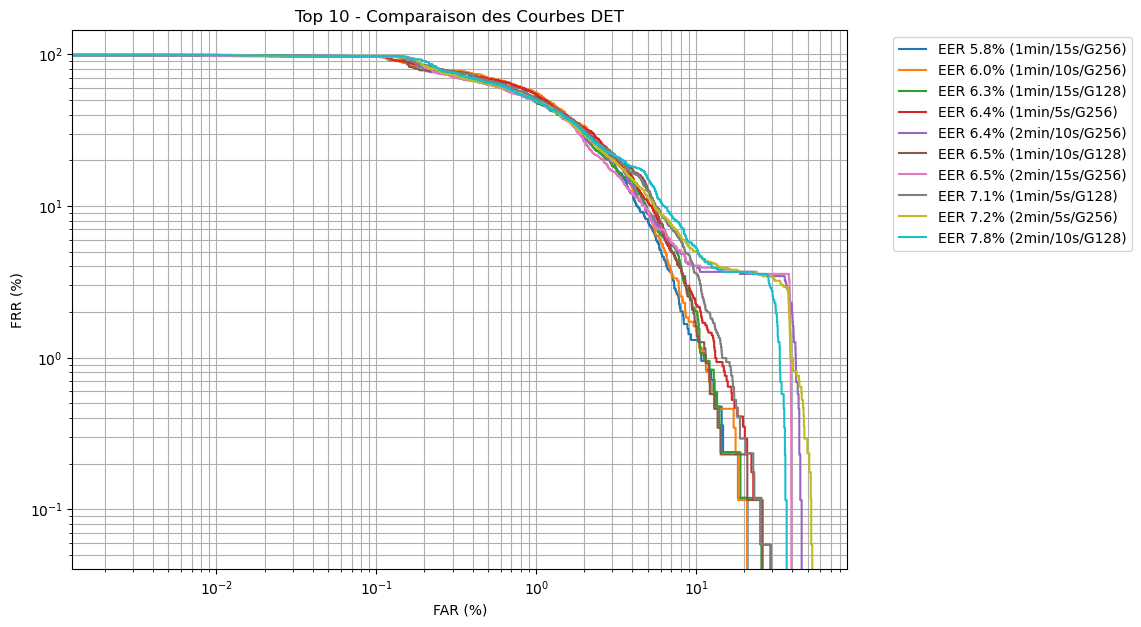


🏆 CLASSEMENT FINAL DES CONFIGURATIONS (EER croissant)
RANG  | TRAIN    | TEST     | GMM   | EER (%)   
--------------------------------------------------
1     | 1min     | 15s      | 256   | 5.76%
2     | 1min     | 10s      | 256   | 5.96%
3     | 1min     | 15s      | 128   | 6.26%
4     | 1min     | 5s       | 256   | 6.37%
5     | 2min     | 10s      | 256   | 6.44%
6     | 1min     | 10s      | 128   | 6.52%
7     | 2min     | 15s      | 256   | 6.54%
8     | 1min     | 5s       | 128   | 7.10%
9     | 2min     | 5s       | 256   | 7.25%
10    | 2min     | 10s      | 128   | 7.81%
11    | 2min     | 15s      | 128   | 7.86%
12    | 1min     | 15s      | 64    | 8.15%
13    | 2min     | 5s       | 128   | 8.54%
14    | 1min     | 5s       | 64    | 8.73%
15    | 1min     | 10s      | 64    | 8.97%
16    | 2min     | 10s      | 64    | 9.38%
17    | 2min     | 15s      | 64    | 9.39%
18    | 1min     | 15s      | 32    | 9.51%
19    | 2min     | 5s       | 64    | 10.05%
20    | 

In [ ]:
import matplotlib.cm as cm

def run_speaker_system_benchmark(compare_all=True, single_train="1min", single_test="10s", single_n=256):
    """
    Si compare_all=True : Évalue toutes les combinaisons et affiche le classement + DET Comparatif.
    Si compare_all=False : Évalue uniquement la config passée en paramètres avec les graphes FAR/FRR.
    """
    speakers = sorted([d for d in os.listdir(MODELS_DIR) if os.path.isdir(os.path.join(MODELS_DIR, d))])
    
    # 1. Pré-chargement de TOUS les audios de test (pour la rapidité)
    print("--- Étape 1 : Chargement des features de test ---")
    test_durs_to_load = TEST_DURATIONS if compare_all else [single_test]
    audio_cache = {d: {} for d in test_durs_to_load}
    
    for td in test_durs_to_load:
        print(f"📂 Cache {td}...", end=" ")
        for spk in speakers:
            files = glob.glob(os.path.join(INPUT_ROOT, spk, "test_segments", f"*{td}*.wav"))
            audio_cache[td][spk] = [f for f in [get_clean_features(w) for w in files] if f is not None]
        print("✅")

    # 2. Définition des combinaisons à tester
    configs = []
    if compare_all:
        for tr in TRAIN_DURATIONS:
            for ts in TEST_DURATIONS:
                for n in N_COMPONENTS_LIST:
                    configs.append((tr, ts, n))
    else:
        configs = [(single_train, single_test, single_n)]

    results_list = []

    # 3. Boucle d'évaluation
    print(f"\n--- Étape 2 : Évaluation de {len(configs)} configuration(s) ---")
    for tr_dur, ts_dur, n_comp in configs:
        y_true, y_scores = [], []
        
        for model_owner in speakers:
            m_path = os.path.join(MODELS_DIR, model_owner, f"{model_owner}_{tr_dur}_{n_comp}.gmm")
            if not os.path.exists(m_path): continue
            gmm = joblib.load(m_path)

            for test_spk, segments in audio_cache[ts_dur].items():
                for seg in segments:
                    y_scores.append(gmm.score(seg))
                    y_true.append(1 if model_owner == test_spk else 0)

        if y_true:
            fpr, fnr, thresholds = det_curve(y_true, y_scores)
            idx = np.nanargmin(np.abs(fpr - fnr))
            eer = fpr[idx]
            
            results_list.append({
                "tr": tr_dur, "ts": ts_dur, "n": n_comp,
                "eer": eer, "fpr": fpr, "fnr": fnr, "thr": thresholds, "idx": idx
            })
            if compare_all: print(f"✅ Config {tr_dur}/{ts_dur}/{n_comp} : EER = {eer*100:.2f}%")

    # 4. Visualisations
    if not compare_all:
        # MODE SINGLE : Visualisation FAR/FRR + DET simple
        res = results_list[0]
        plt.figure(figsize=(15, 5))
        
        # Graphe 1 : FAR / FRR
        plt.subplot(1, 2, 1)
        plt.plot(res["thr"], res["fpr"] * 100, label='FAR (Faux Positifs)', color='red')
        plt.plot(res["thr"], res["fnr"] * 100, label='FRR (Faux Négatifs)', color='blue')
        plt.axvline(res["thr"][res["idx"]], color='black', linestyle='--', label=f'EER Threshold')
        plt.title(f"FAR vs FRR (EER: {res['eer']*100:.2f}%)\nTrain:{single_train} Test:{single_test} GMM:{single_n}")
        plt.xlabel("Seuil Score"); plt.ylabel("Taux (%)"); plt.legend(); plt.grid(True)

        # Graphe 2 : DET
        plt.subplot(1, 2, 2)
        plt.plot(res["fpr"] * 100, res["fnr"] * 100, color='purple', lw=2)
        plt.xscale('log'); plt.yscale('log')
        plt.xlabel('FAR (%)'); plt.ylabel('FRR (%)'); plt.title("Courbe DET (Log)")
        plt.grid(True, which="both")
        plt.show()
        
    else:
        # MODE COMPARE ALL : Courbe DET multiple + Tableau
        results_list.sort(key=lambda x: x["eer"])
        
        plt.figure(figsize=(10, 7))
        colors = cm.get_cmap('tab10', 10)
        for i, res in enumerate(results_list[:10]): # Top 10 pour la lisibilité
            plt.plot(res["fpr"]*100, res["fnr"]*100, 
                     label=f"EER {res['eer']*100:.1f}% ({res['tr']}/{res['ts']}/G{res['n']})")
        
        plt.xscale('log'); plt.yscale('log')
        plt.title("Top 10 - Comparaison des Courbes DET")
        plt.xlabel("FAR (%)"); plt.ylabel("FRR (%)"); plt.legend(bbox_to_anchor=(1.05, 1)); plt.grid(True, which="both")
        plt.show()

        # Tableau de classement
        print("\n🏆 CLASSEMENT FINAL DES CONFIGURATIONS (EER croissant)")
        print(f"{'RANG':<5} | {'TRAIN':<8} | {'TEST':<8} | {'GMM':<5} | {'EER (%)':<10}")
        print("-" * 50)
        for i, res in enumerate(results_list):
            print(f"{i+1:<5} | {res['tr']:<8} | {res['ts']:<8} | {res['n']:<5} | {res['eer']*100:.2f}%")

# --- EXÉCUTION ---

run_speaker_system_benchmark(compare_all=True)

📊 Évaluation : Train=1min, Test=15s, GMM=256


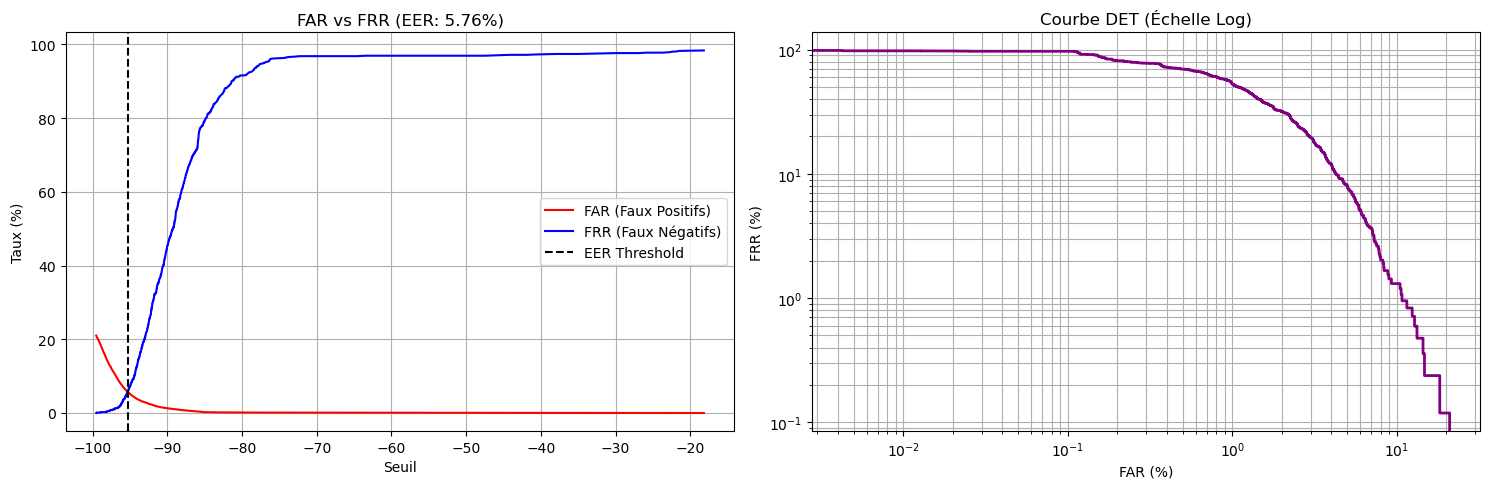

✅ EER Global du système : 5.76%


In [15]:
def run_full_benchmark(train_dur="1min", test_dur="15s", n_comp=256):
    speakers = [d for d in os.listdir(MODELS_DIR)]
    
    print(f"📊 Évaluation : Train={train_dur}, Test={test_dur}, GMM={n_comp}")
    
    # 1. Chargement des features de test
    test_db = {}
    for spk in speakers:
        files = glob.glob(os.path.join(INPUT_ROOT, spk, "test_segments", f"*{test_dur}*.wav"))
        test_db[spk] = [f for f in [get_clean_features(w) for w in files] if f is not None]

    y_true, y_scores = [], []

    # 2. Scoring
    for model_owner in speakers:
        path = os.path.join(MODELS_DIR, model_owner, f"{model_owner}_{train_dur}_{n_comp}.gmm")
        if not os.path.exists(path): continue
        gmm = joblib.load(path)

        for test_spk, segments in test_db.items():
            for seg in segments:
                score = gmm.score(seg)
                y_scores.append(score)
                y_true.append(1 if model_owner == test_spk else 0)

    # 3. Calculs et Visualisation
    fpr, fnr, thresholds = det_curve(y_true, y_scores)
    idx = np.nanargmin(np.abs(fpr - fnr))
    eer = fpr[idx]

    plt.figure(figsize=(15, 5))

    # Graphe 1 : FAR / FRR
    plt.subplot(1, 2, 1)
    plt.plot(thresholds, fpr * 100, label='FAR (Faux Positifs)', color='red')
    plt.plot(thresholds, fnr * 100, label='FRR (Faux Négatifs)', color='blue')
    plt.axvline(thresholds[idx], color='black', linestyle='--', label=f'EER Threshold')
    plt.title(f"FAR vs FRR (EER: {eer*100:.2f}%)")
    plt.xlabel("Seuil"); plt.ylabel("Taux (%)"); plt.legend(); plt.grid(True)

    # Graphe 2 : Courbe DET
    plt.subplot(1, 2, 2)
    plt.plot(fpr * 100, fnr * 100, color='purple', lw=2)
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('FAR (%)'); plt.ylabel('FRR (%)')
    plt.title("Courbe DET (Échelle Log)")
    plt.grid(True, which="both")
    
    plt.tight_layout()
    plt.show()
    print(f"✅ EER Global du système : {eer*100:.2f}%")

# Lancer l'évaluation
run_full_benchmark(train_dur="1min", test_dur="15s", n_comp=256)

📈 CALCUL DES PERFORMANCES INDIVIDUELLES
Configuration : Train=1min, Test=15s, GMM=256



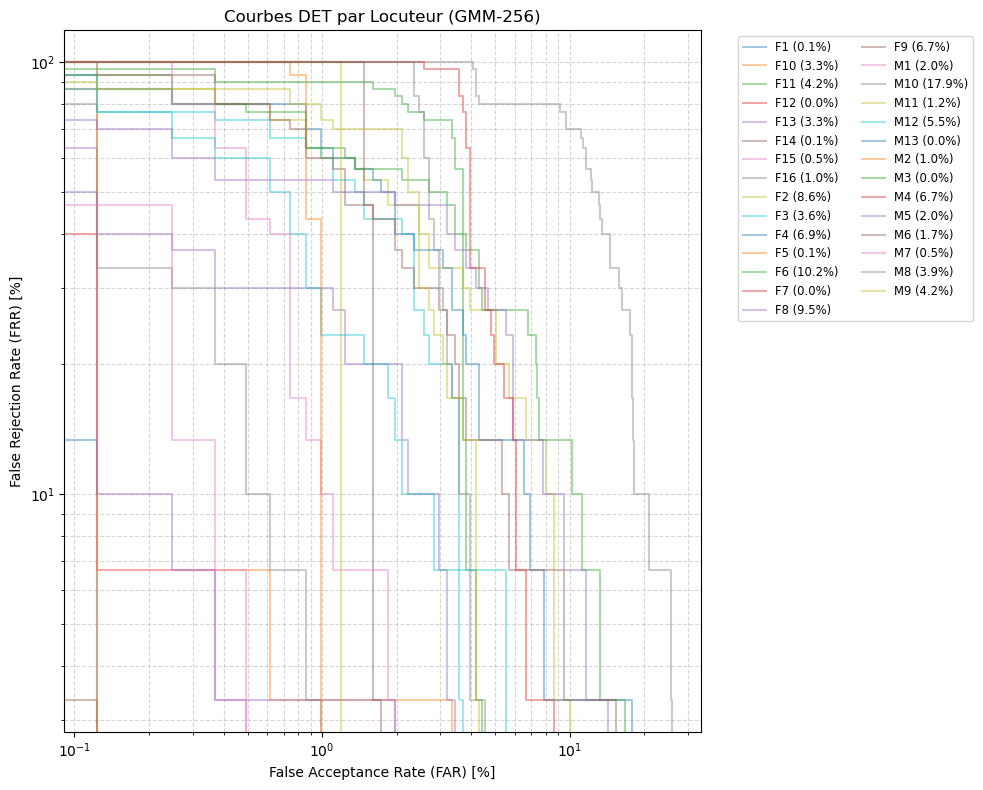


=== CLASSEMENT DES PERFORMANCES (EER - Plus bas est mieux) ===
F12   : 0.00%
F7    : 0.00%
M13   : 0.00%
M3    : 0.00%
F1    : 0.12%
F14   : 0.12%
F5    : 0.12%
F15   : 0.49%
M7    : 0.49%
F16   : 0.99%
M2    : 0.99%
M11   : 1.19%
M6    : 1.73%
M1    : 1.97%
M5    : 1.97%
F10   : 3.33%
F13   : 3.33%
F3    : 3.58%
M8    : 3.95%
F11   : 4.19%
M9    : 4.19%
M12   : 5.55%
F9    : 6.66%
M4    : 6.66%
F4    : 6.91%
F2    : 8.63%
F8    : 9.49%
F6    : 10.23%
M10   : 17.88%
👉 EER MOYEN DU SYSTÈME : 3.61%


In [11]:
def speaker_det_benchmark(train_dur="1min", test_dur="15s", n_comp=256):
    print(f"📈 CALCUL DES PERFORMANCES INDIVIDUELLES")
    print(f"Configuration : Train={train_dur}, Test={test_dur}, GMM={n_comp}\n")
    speakers = sorted([d for d in os.listdir(MODELS_DIR) if os.path.isdir(os.path.join(MODELS_DIR, d))])
    MODELS_ROOT = "./trained_models_per_person"
    # 1. Pré-chargement des features de test (pour la rapidité)
    test_db = {}
    for spk in speakers:
        files = glob.glob(os.path.join(INPUT_ROOT, spk, "test_segments", f"*{test_dur}*.wav"))
        test_db[spk] = [f for f in [get_clean_features(w) for w in files] if f is not None]

    plt.figure(figsize=(10, 8))
    eer_results = {} # Dictionnaire pour stocker {Locuteur: Valeur EER}

    # 2. Boucle de test : on teste chaque modèle contre tout le monde
    for model_owner in speakers:
        m_path = os.path.join(MODELS_ROOT, model_owner, f"{model_owner}_{train_dur}_{n_comp}.gmm")
        if not os.path.exists(m_path): continue
        
        gmm = joblib.load(m_path)
        y_true, y_scores = [], []

        for test_spk, segments in test_db.items():
            for seg in segments:
                score = gmm.score(seg)
                y_scores.append(score)
                y_true.append(1 if model_owner == test_spk else 0)

        # Calcul de la courbe DET pour ce locuteur précis
        if len(np.unique(y_true)) > 1:
            fpr, fnr, _ = det_curve(y_true, y_scores)
            idx = np.nanargmin(np.abs(fpr - fnr))
            eer_val = fpr[idx]
            eer_results[model_owner] = eer_val # Sauvegarde pour le classement
            
            # Tracé de la courbe DET individuelle
            plt.plot(fpr*100, fnr*100, alpha=0.4, label=f"{model_owner} ({eer_val*100:.1f}%)")

    # 3. Mise en forme du graphique DET
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('False Acceptance Rate (FAR) [%]')
    plt.ylabel('False Rejection Rate (FRR) [%]')
    plt.title(f'Courbes DET par Locuteur (GMM-{n_comp})')
    plt.grid(True, which="both", linestyle='--', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()

    # 4. AFFICHAGE DU CLASSEMENT TEXTUEL (Demandé)
    print("\n" + "="*60)
    print("=== CLASSEMENT DES PERFORMANCES (EER - Plus bas est mieux) ===")
    
    # Tri des résultats par valeur d'EER (x[1]) de façon croissante
    sorted_eer = sorted(eer_results.items(), key=lambda x: x[1])
    
    for spk, eer in sorted_eer:
        print(f"{spk:<5} : {eer*100:.2f}%")
    
    # Calcul de la moyenne globale
    avg_eer = np.mean(list(eer_results.values()))
    print("="*60)
    print(f"👉 EER MOYEN DU SYSTÈME : {avg_eer*100:.2f}%")
    print("="*60)

# Lancer l'analyse
speaker_det_benchmark(train_dur="1min", test_dur="15s", n_comp=256)